## Making training data

This notebook describes the workflow for generating training data
from templates

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import models
import platform

from pathlib import Path
from os.path import expanduser
from os import path, getcwd
import logging

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn_evaluation import plot as sk_plot

import yass
from yass import read_config, preprocess, detect
from yass import util
from yass.augment import make
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage, AutoEncoder 
from yass.explore import RecordingExplorer, SpikeTrainExplorer
from yass.augment.noise import noise_cov
from yass.templates import TemplatesProcessor
from yass.augment.util import amplitudes

import numpy as np
from scipy.io import loadmat

from dstools import plot, Env
from dstools.reproducibility import make_filename
from dstools.reproducibility.util import get_version, git_hash_in_path
from dstools.util import save

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from sklearn.model_selection import train_test_split

# logging.basicConfig(level=logging.DEBUG)

Using TensorFlow backend.


In [3]:
here = getcwd()
here_version = git_hash_in_path(here)

In [4]:
env = Env()

In [5]:
# for reference
print('YASS version is: {}'.format(util.get_version()))
print('nbs version is: {}'.format(here_version))

YASS version is: f6dd519 removing split
nbs version is: 2835c5c updates


In [6]:
path_to_config = str(Path(env.project_home, 'config/gcloud/49/default.yaml'))
yass.set_config(path_to_config)
CONFIG = read_config()

In [7]:
path_to_data = env.path.data
path_to_ground_truth = path.join(path_to_data,
                                 'groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'retinal', 'sample_output')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'ej49_geometry1.txt')
path_to_here = path.expanduser('~/dev/private-yass/nnet')
path_to_output = Path(path_to_data, 'triage', 'sets')

## Loading templates

In [8]:
raw_templates = np.load(Path(env.path.data, 'cat/templates-jul27-only-good.npy'))
_, waveform_length, _ = raw_templates.shape
print(raw_templates.shape)

(240, 61, 49)


In [9]:
# crop spatially
processor = TemplatesProcessor(raw_templates)
templates = (processor
            .crop_spatially(CONFIG.neigh_channels, CONFIG.geom)
            .values)
templates.shape

(240, 61, 7)

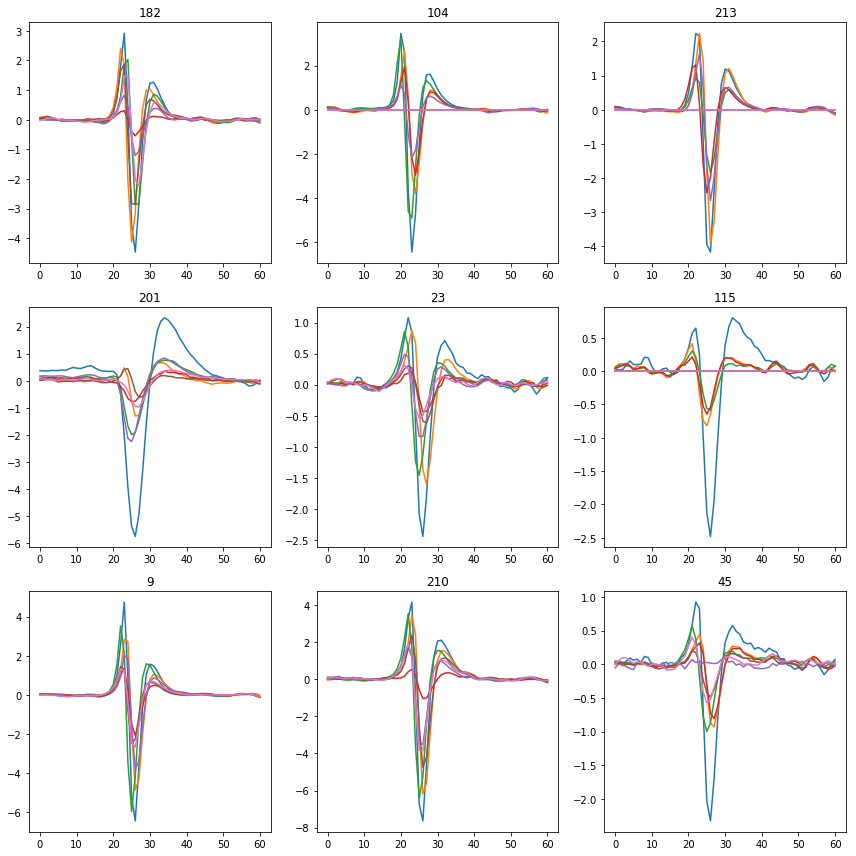

In [10]:
plot.grid_from_array(templates, axis=0, auto_figsize=4,
                     max_cols=3, elements=9)

## Generating training data

In [11]:
min_amplitude = 4
max_amplitude = 60

n_clean_per_template = 150
n_collided_per_spike = 1
max_shift = 15
min_shift = 4

In [12]:
(spatial_sig,
 temporal_sig) = noise_cov(path_to_standarized,
                           CONFIG.neigh_channels,
                           CONFIG.geom,
                           waveform_length,
                           sample_size=1000,
                           threshold=3.0)

In [13]:
(x_train_large, y_train) = make.training_data_triage(templates,
                                       min_amplitude,
                                       max_amplitude,
                                       n_clean_per_template,
                                       n_collided_per_spike,
                                       max_shift,
                                       min_shift,
                                       spatial_sig,
                                       temporal_sig,
                                       return_metadata=True)

In [14]:
x_train_large.shape

(72000, 61, 7)

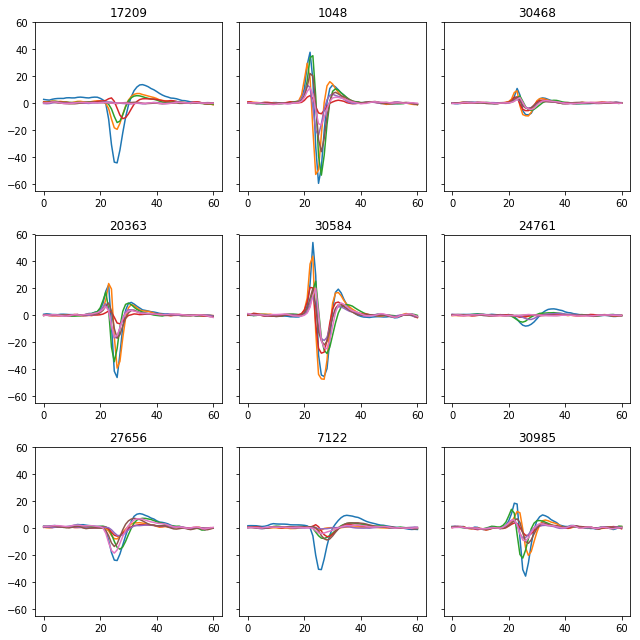

In [15]:
plot.grid_from_array(x_train_large[y_train == 1], axis=0,
                     elements=9, auto_figsize=3,
                     sharey=True)

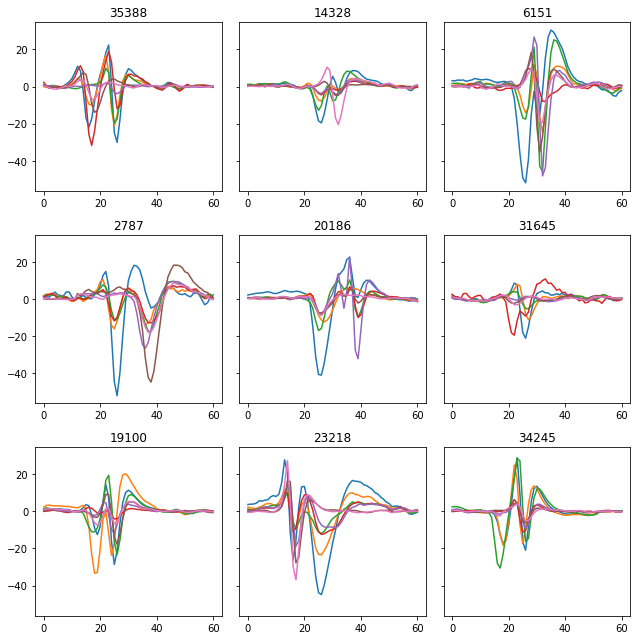

In [16]:
plot.grid_from_array(x_train_large[y_train == 0], axis=0,
                     elements=9, auto_figsize=3,
                     sharey=True)

In [18]:
metadata = x_train_large.metadata[1]

collided_large = x_train_large[y_train == 0]
collided_first_large = metadata['first']
collided_second_large = metadata['second']

shift = metadata['shift']
labels = ['{}, shift: {}'.format(i, shift[i]) for i in range(collided_large.shape[0])]

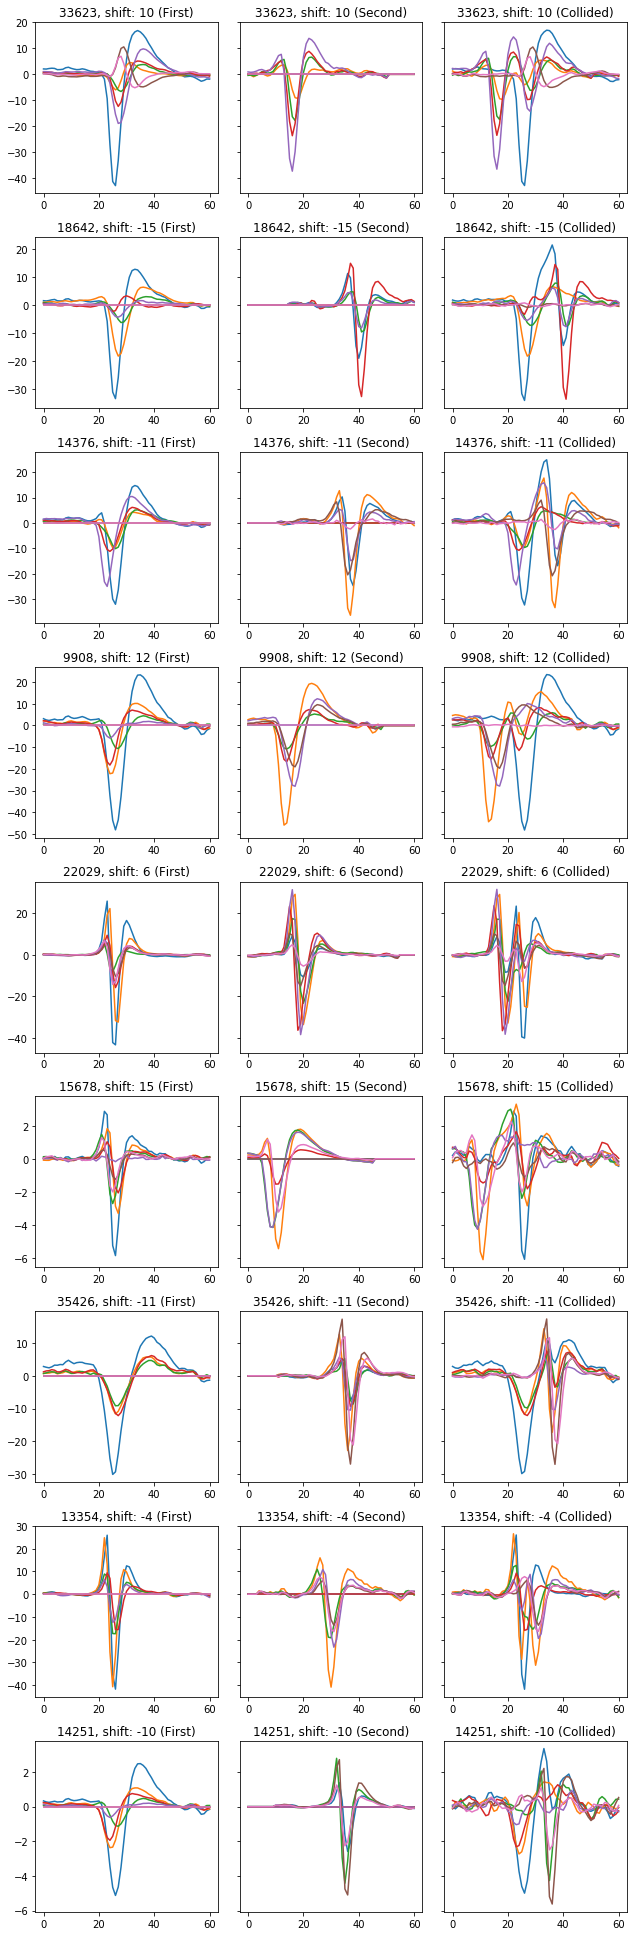

In [19]:
plot.grid_from_array([collided_first_large, collided_second_large, collided_large],
                     axis=0,
                     group_names=['First', 'Second', 'Collided'],
                     auto_figsize=3,
                     sharey='row',
                     labels=labels,
                     elements=9)

In [20]:
x_train = TemplatesProcessor(x_train_large).crop_temporally(15).values

In [21]:
x_train.shape

(72000, 31, 7)

In [22]:
collided = x_train[y_train == 0]
collided_first = TemplatesProcessor(collided_first_large).crop_temporally(15).values
collided_second = TemplatesProcessor(collided_second_large).crop_temporally(15).values 

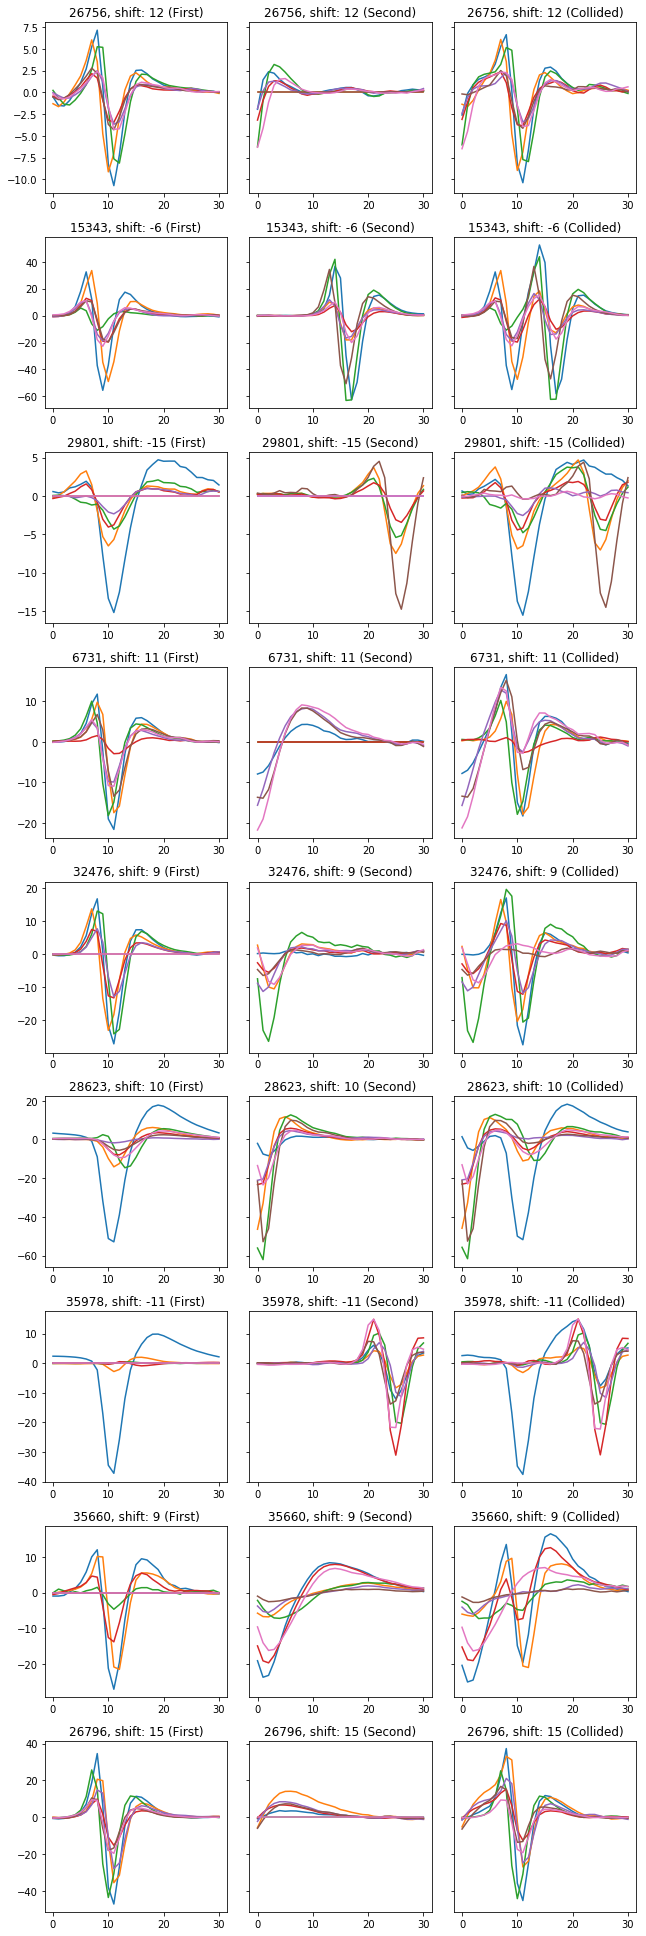

In [23]:
plot.grid_from_array([collided_first, collided_second, collided],
                     axis=0,
                     group_names=['First', 'Second', 'Collided'],
                     elements=9,
                     auto_figsize=3,
                     sharey='row',
                     labels=labels)

In [24]:
clean = x_train[y_train == 1]

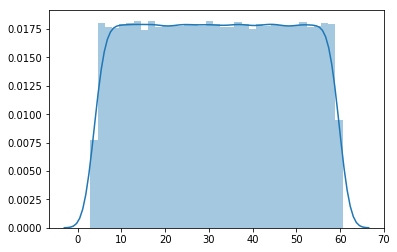

In [25]:
sns.distplot(amplitudes(clean))

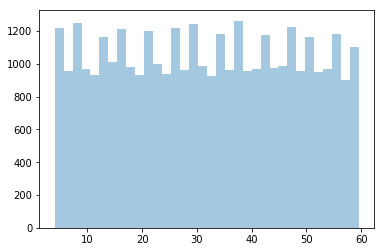

In [26]:
sns.distplot(amplitudes(collided_first), kde=False)

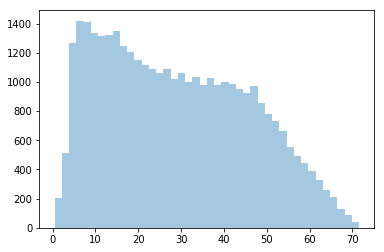

In [27]:
sns.distplot(amplitudes(collided_second), kde=False)

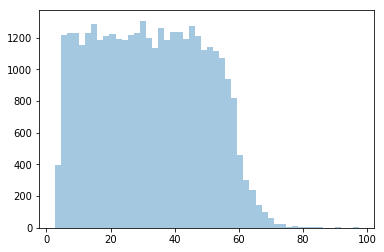

In [28]:
sns.distplot(amplitudes(collided), kde=False)

In [29]:
metadata_to_save = metadata['params']
metadata_to_save['shape'] = list(x_train.shape)
metadata_to_save['nb_version'] = git_hash_in_path(getcwd())

print(metadata_to_save)

{'n_per_spike': 1, 'multi_channel': True, 'min_shift': 4, 'max_shift': 15, 'amp_tolerance': 0.2, 'yass_version': 'f6dd519 removing split', 'shape': [72000, 31, 7], 'nb_version': '2835c5c updates'}


In [30]:
_, wf, ch, = x_train.shape
sufixes = [f'{i}-{wf}wf{ch}ch' for i in ('x-train', 'x-test', 'y-train', 'y-test')]

In [31]:
filenames = make_filename(sufix=sufixes, extension='npy') + [make_filename('metadata', 'yaml')]
filenames

['2018-08-21T00-49-52:x-train-31wf7ch.npy',
 '2018-08-21T00-49-52:x-test-31wf7ch.npy',
 '2018-08-21T00-49-52:y-train-31wf7ch.npy',
 '2018-08-21T00-49-52:y-test-31wf7ch.npy',
 '2018-08-21T00-49-52:metadata.yaml']

In [32]:
sets = train_test_split(x_train, y_train, test_size=0.33)

In [33]:
objs = sets + [metadata_to_save]

for name, obj in zip(filenames, objs):
    path = str(path_to_output / name)
    print(f'Saving {path}...')
    save(obj, path)

Saving /home/Edu/data/triage/sets/2018-08-21T00-49-52:x-train-31wf7ch.npy...
Saving /home/Edu/data/triage/sets/2018-08-21T00-49-52:x-test-31wf7ch.npy...
Saving /home/Edu/data/triage/sets/2018-08-21T00-49-52:y-train-31wf7ch.npy...
Saving /home/Edu/data/triage/sets/2018-08-21T00-49-52:y-test-31wf7ch.npy...
Saving /home/Edu/data/triage/sets/2018-08-21T00-49-52:metadata.yaml...
